<a href="https://colab.research.google.com/github/Saba-a11/Kaggle_Credit_Score/blob/main/CreditModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [30]:
from ast import increment_lineno
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Import Data

In [157]:
df_train = pd.read_csv("/content/drive/MyDrive/Data_Kaggle_GiveMeSomeCredit/cs-training.csv")
df_test = pd.read_csv("/content/drive/MyDrive/Data_Kaggle_GiveMeSomeCredit/cs-test.csv")

In [32]:
df_train.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [33]:
df_test.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,NaN,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0
1,2,NaN,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0
2,3,NaN,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0
3,4,NaN,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0
4,5,NaN,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0


### based on Data Dictionary, Variable Name, Description and Type are:

* `SeriousDlqin2yrs` Person experienced 90 days past due delinquency or
worse. **Y/N**
* `RevolvingUtilizationOfUnsecuredLines` Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits. **percentage**
* `age` Age of borrower in years. **integer**
* `NumberOfTime3059DaysPastDueNotWorse` Number of times borrower has been 30-59 days past due but no worse in the last 2 years. **integer**
* `DebtRatio` Monthly debt payments, alimony,living costs divided by monthy gross income **percentage**
* `MonthlyIncome Monthly` income **real**
* `NumberOfOpenCreditLinesAndLoans` Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards) **integer**
* `NumberOfTimes90DaysLate` Number of times borrower has been 90 days or more past due. **integer**
* `NumberRealEstateLoansOrLines` Number of mortgage and real estate loans including home equity lines of credit **integer**
* `NumberOfTime60-89DaysPastDueNotWorse` Number of times borrower has been 60-89 days past due but no worse in the last 2 years. **integer**
* `NumberOfDependents` Number of dependents in family excluding themselves (spouse, children etc.) **integer**

# Exploratory Data Analysis

In [34]:
print('Train shape: ', df_train.shape)
print('Test shape: ', df_test.shape)

Train shape:  (150000, 12)
Test shape:  (101503, 12)


In [35]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 11  

In [36]:
df_train.describe()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,75000.500000,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,43301.414527,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37500.750000,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,75000.500000,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,112500.250000,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,150000.000000,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


In [37]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101503 entries, 0 to 101502
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            101503 non-null  int64  
 1   SeriousDlqin2yrs                      0 non-null       float64
 2   RevolvingUtilizationOfUnsecuredLines  101503 non-null  float64
 3   age                                   101503 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  101503 non-null  int64  
 5   DebtRatio                             101503 non-null  float64
 6   MonthlyIncome                         81400 non-null   float64
 7   NumberOfOpenCreditLinesAndLoans       101503 non-null  int64  
 8   NumberOfTimes90DaysLate               101503 non-null  int64  
 9   NumberRealEstateLoansOrLines          101503 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  101503 non-null  int64  
 11  

In [38]:
df_test.describe()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,101503.000000,0.0,101503.000000,101503.000000,101503.000000,101503.000000,8.140000e+04,101503.000000,101503.000000,101503.000000,101503.000000,98877.000000
mean,50752.000000,NaN,5.310000,52.405436,0.453770,344.475020,6.855036e+03,8.453514,0.296691,1.013074,0.270317,0.769046
std,29301.536524,NaN,196.156039,14.779756,4.538487,1632.595231,3.650860e+04,5.144100,4.515859,1.110253,4.503578,1.136778
min,1.000000,NaN,0.000000,21.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25376.500000,NaN,0.030131,41.000000,0.000000,0.173423,3.408000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,50752.000000,NaN,0.152586,52.000000,0.000000,0.364260,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,76127.500000,NaN,0.564225,63.000000,0.000000,0.851619,8.200000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,101503.000000,NaN,21821.000000,104.000000,98.000000,268326.000000,7.727000e+06,85.000000,98.000000,37.000000,98.000000,43.000000


# Data Preprocessing

### Unnamed: 0 Column

The `Unnamed: 0` column holds no relevance in the context of predictive modeling as it solely represents the customer's identification. Consequently, it is imperative to exclude this column from the model for enhanced accuracy and efficiency.

In [158]:
trainID = df_train['Unnamed: 0']
testID = df_test['Unnamed: 0']

df_train.drop('Unnamed: 0', axis=1, inplace=True)
df_test.drop('Unnamed: 0', axis=1, inplace=True)

### SeriousDlqin2yrs Column

An imbalanced target column in a dataset, particularly in the context of binary classification, implies that the distribution of the classes is uneven. `SeriousDlqin2yrs` column has an imbalance, with a default rate of **6.7%**.

In [102]:
sns.set_palette('plasma')    # magma, crest, rocket_r, flare, mako, rocket, viridis, plasma, cividis
sns.set_style('whitegrid')

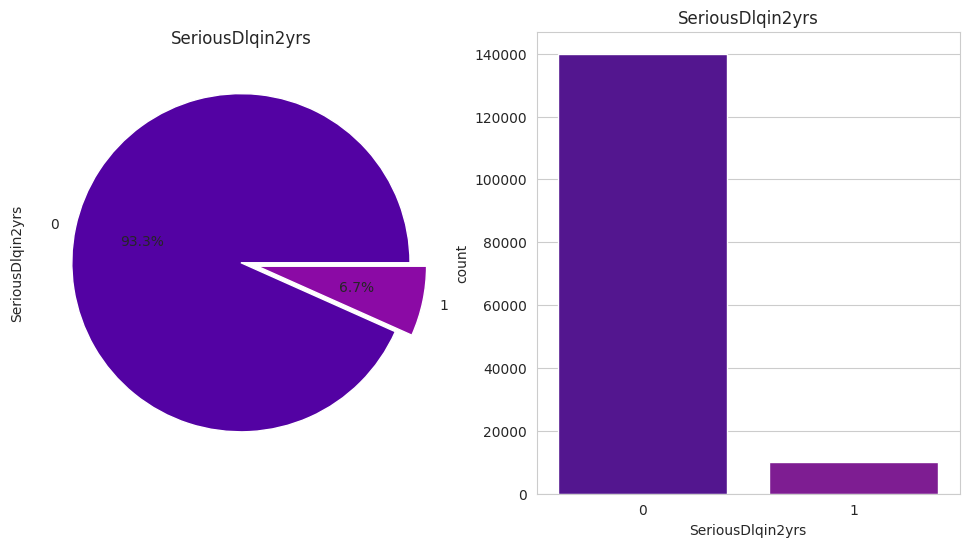

In [103]:
fig, axes = plt.subplots(1,2,figsize=(12,6))

df_train['SeriousDlqin2yrs'].value_counts().plot.pie(explode=[0,0.1], autopct='%1.1f%%',ax=axes[0])
axes[0].set_title('SeriousDlqin2yrs')

sns.countplot(x='SeriousDlqin2yrs', data=df_train, ax=axes[1])
axes[1].set_title('SeriousDlqin2yrs')

plt.show()



### Consequences of Imbalanced Data:
**Bias Towards Majority Class:** Machine learning models trained on imbalanced data may exhibit a bias
toward the majority class. In your case, this could mean the model is more inclined to predict non-default.

**Reduced Sensitivity to Minority Class:** The model may have difficulty correctly predicting instances of the minority class (defaults) due to its lower prevalence.

### Strategies to Balance the Data:
**Resampling:**
  * **Oversampling Minority Class:** Increase the number of instances in the minority class to balance the class distribution.
  * **Undersampling Majority Class:** Decrease the number of instances in the majority class to achieve a balanced dataset.

**Synthetic Data Generation:** Use techniques like Synthetic Minority Over-sampling Technique (SMOTE) to generate synthetic examples for the minority class.

**Algorithmic Approaches:** Utilize algorithms designed to handle imbalanced datasets, such as ensemble methods like Balanced Random Forest or algorithms with class weight adjustments.

**Evaluation Metrics:** Instead of solely relying on accuracy, use metrics like precision, recall, F1-score, or area under the ROC curve (AUC-ROC) that are more informative for imbalanced datasets.

### RevolvingUtilizationOfUnsecuredLines Column

In [66]:
def prt_corr(column_of_interest, target_column):
  # Calculate the correlation
  correlation = df_train[column_of_interest].corr(df_train[target_column])
  print(f"Correlation between {column_of_interest} and {target_column}: {correlation}")

In [58]:
def scatter_plot(column_of_interest, target_column):
  # Scatter plot
  plt.figure(figsize=(8, 6))
  sns.scatterplot(x=df_train[column_of_interest], y=df_train[target_column])
  plt.title(f'Scatter Plot between {column_of_interest} and {target_column}')
  plt.xlabel(column_of_interest)
  plt.ylabel(target_column)
  plt.show()

In [59]:
df_train["RevolvingUtilizationOfUnsecuredLines"].describe()

count    150000.000000
mean          6.048438
std         249.755371
min           0.000000
25%           0.029867
50%           0.154181
75%           0.559046
max       50708.000000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64

In [60]:
prt_corr('RevolvingUtilizationOfUnsecuredLines', 'SeriousDlqin2yrs')

Correlation between RevolvingUtilizationOfUnsecuredLines and SeriousDlqin2yrs: -0.0018015025039439683


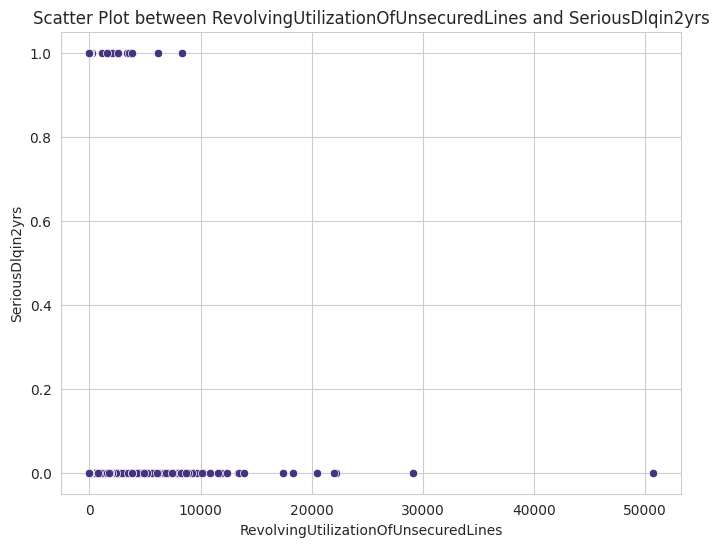

In [61]:
scatter_plot('RevolvingUtilizationOfUnsecuredLines', 'SeriousDlqin2yrs')

In [ ]:
# sns.jointplot(x=column_of_interest, y=target_column, data=df_train, color='purple')

In [159]:
# Calculate IQR
Q1 = df_train['RevolvingUtilizationOfUnsecuredLines'].quantile(0.25)
Q3 = df_train['RevolvingUtilizationOfUnsecuredLines'].quantile(0.75)
IQR = Q3 - Q1

# Identify potential outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to exclude outliers
df_no_outliers = df_train[(df_train['RevolvingUtilizationOfUnsecuredLines'] >= lower_bound) & (df_train['RevolvingUtilizationOfUnsecuredLines'] <= upper_bound)]

# Impute outliers with the median
median_value = df_train['RevolvingUtilizationOfUnsecuredLines'].median()
df_train['RevolvingUtilizationOfUnsecuredLines'] = df_train['RevolvingUtilizationOfUnsecuredLines'].apply(lambda x: median_value if x < lower_bound or x > upper_bound else x)


In [63]:
df_train["RevolvingUtilizationOfUnsecuredLines"].describe()

count    150000.000000
mean          0.316163
std           0.349067
min           0.000000
25%           0.029867
50%           0.154178
75%           0.546719
max           1.352159
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64

It's perfectly fine for the maximum value of the `RevolvingUtilizationOfUnsecuredLines` column to be more than 1 after the outlier handling. This could happen as a result of data transformations, imputations, or capping the extreme values during the outlier removal process.

In many cases, transforming or capping values can bring the distribution closer to a more standardized or normal distribution, and it's not uncommon for transformed or capped values to exceed the original range of the data.

The key consideration is whether the adjusted data aligns more closely with the expected distribution for your analysis and whether it addresses the issues caused by the outliers. In the context of credit scoring or similar applications, ensuring that the data is more representative of the actual distribution and doesn't introduce bias into your models is crucial.

In [64]:
prt_corr('RevolvingUtilizationOfUnsecuredLines', 'SeriousDlqin2yrs')

Correlation between RevolvingUtilizationOfUnsecuredLines and SeriousDlqin2yrs: 0.2722239810557289


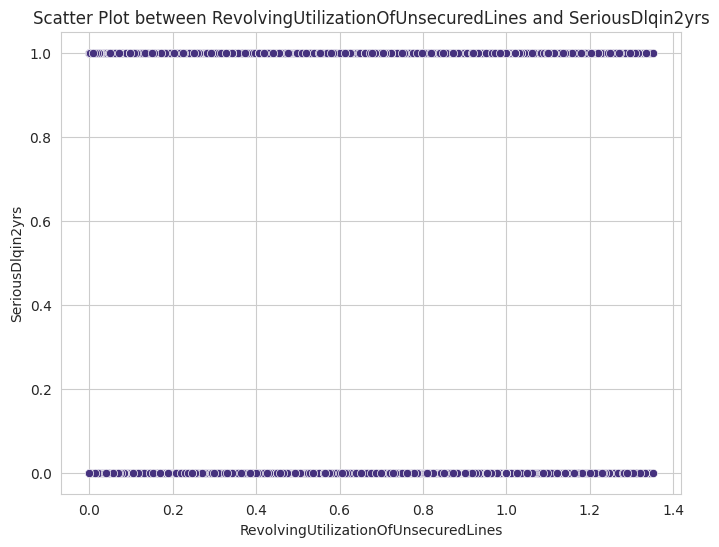

In [65]:
scatter_plot('RevolvingUtilizationOfUnsecuredLines', 'SeriousDlqin2yrs')

### Age Column

In [69]:
df_train["age"].describe()

count    150000.000000
mean         52.295207
std          14.771866
min           0.000000
25%          41.000000
50%          52.000000
75%          63.000000
max         109.000000
Name: age, dtype: float64

In [73]:
prt_corr('age', 'SeriousDlqin2yrs')

Correlation between age and SeriousDlqin2yrs: -0.11538551846889132


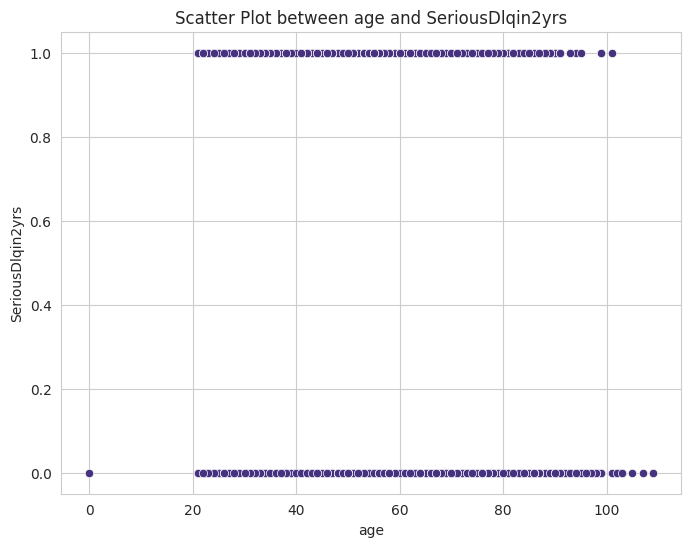

In [74]:
scatter_plot('age', 'SeriousDlqin2yrs')

Dealing with outliers in the `age` column is essential for building accurate models. In your case, you've identified that there are instances where age is recorded as 0, which is likely an error or missing data. Here are steps to handle this situation:

**Identify and Handle Outliers:**
1. **Imputation:** If the number of instances with age = 0 is small, you may consider imputing these values with a reasonable estimate. This could be the mean or median age, depending on the distribution of the rest of the data.

2. **Remove Incorrect Data:** If the instances with age = 0 are an error or cannot be reasonably imputed, consider removing those rows from your dataset.

3. **Set a Threshold:** If the age=0 is unrealistic and indicates a data entry error, you can set a threshold below which values are considered invalid (e.g., age < 18), and either remove or impute those values.

In [75]:
zero_age_count = (df_train['age'] == 0).sum()
print(f"Number of values equal to zero in the 'age' column: {zero_age_count}")

Number of values equal to zero in the 'age' column: 1


In [160]:
# Impute age=0 with the median age
median_age = df_train['age'].median()
df_train['age'] = df_train['age'].replace(0, median_age)

In [77]:
prt_corr('age', 'SeriousDlqin2yrs')

Correlation between age and SeriousDlqin2yrs: -0.11539662019283052


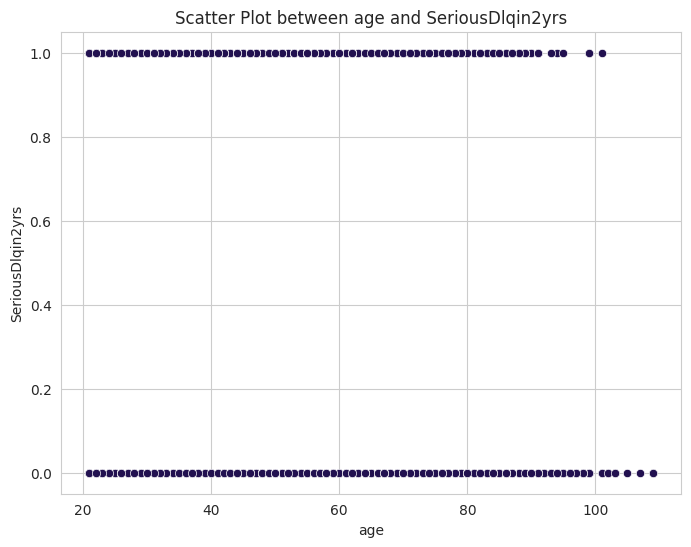

In [80]:
scatter_plot('age', 'SeriousDlqin2yrs')

<ipython-input-109-e0dc42d50907>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train.loc[df_train["SeriousDlqin2yrs"] == 0]["age"], ax=axes[0])
<ipython-input-109-e0dc42d50907>:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train.loc[df_train["SeriousDlqin2yrs"] == 1]["age"], ax=axes

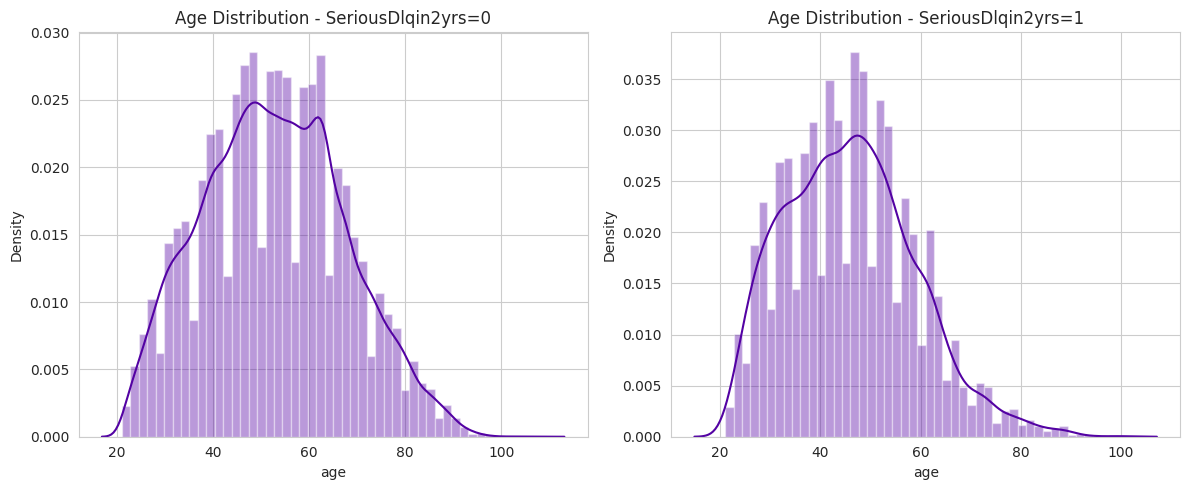

In [109]:
# Set the color palette (you can choose another palette)
sns.set_palette('plasma')
sns.set_style('whitegrid')

# Create a figure with two subplots in one row
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot for 'SeriousDlqin2yrs' == 0
sns.distplot(df_train.loc[df_train["SeriousDlqin2yrs"] == 0]["age"], ax=axes[0])
axes[0].set_title('Age Distribution - SeriousDlqin2yrs=0')

# Plot for 'SeriousDlqin2yrs' == 1
sns.distplot(df_train.loc[df_train["SeriousDlqin2yrs"] == 1]["age"], ax=axes[1])
axes[1].set_title('Age Distribution - SeriousDlqin2yrs=1')

# Adjust layout
plt.tight_layout()
plt.show()

### Overdue Payment Indicators

* `NumberOfTimes90DaysLate`
* `NumberOfTime60-89DaysPastDueNotWorse`
* `NumberOfTime30-59DaysPastDueNotWorse`

In [111]:
late_pay_cols = ["NumberOfTimes90DaysLate", "NumberOfTime60-89DaysPastDueNotWorse", "NumberOfTime30-59DaysPastDueNotWorse"]
df_train[late_pay_cols].describe()

,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,NumberOfTime30-59DaysPastDueNotWorse
count,150000.000000,150000.000000,150000.000000
mean,0.265973,0.240387,0.421033
std,4.169304,4.155179,4.192781
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,98.000000,98.000000,98.000000


In [129]:
# Create three tables
count_90_days = df_train["NumberOfTimes90DaysLate"].value_counts().sort_index()
count_60_89_days = df_train["NumberOfTime60-89DaysPastDueNotWorse"].value_counts().sort_index()
count_30_59_days = df_train["NumberOfTime30-59DaysPastDueNotWorse"].value_counts().sort_index()

# Concatenate the value counts into a single DataFrame
result_df = pd.concat([count_90_days, count_60_89_days, count_30_59_days], axis=1)

# Rename the columns for clarity
result_df.columns = ['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate']

# Display the resulting DataFrame
print(result_df.to_string())

    NumberOfTime30-59DaysPastDueNotWorse  NumberOfTime60-89DaysPastDueNotWorse  NumberOfTimes90DaysLate
0                                 141662                              142396.0                 126018.0
1                                   5243                                5731.0                  16033.0
2                                   1555                                1118.0                   4598.0
3                                    667                                 318.0                   1754.0
4                                    291                                 105.0                    747.0
5                                    131                                  34.0                    342.0
6                                     80                                  16.0                    140.0
7                                     38                                   9.0                     54.0
8                                     21                        

In [161]:
# Remove rows with suspicious values (96 and 98)
df_train = df_train[~df_train["NumberOfTimes90DaysLate"].isin([96, 98])]

In [132]:
df_train[late_pay_cols].describe()

,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,NumberOfTime30-59DaysPastDueNotWorse
count,149731.000000,149731.000000,149731.000000
mean,0.090456,0.064823,0.245794
std,0.485527,0.330073,0.697780
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,17.000000,11.000000,13.000000


In [134]:
# Calculate the correlation
df_corr = df_train[["NumberOfTime30-59DaysPastDueNotWorse", "NumberOfTime60-89DaysPastDueNotWorse", "NumberOfTimes90DaysLate", "SeriousDlqin2yrs"]]

# Calculate the correlation matrix
correlation_matrix = df_corr.corr()

# Print the correlation matrix
print(correlation_matrix.to_string())

                                      NumberOfTime30-59DaysPastDueNotWorse  NumberOfTime60-89DaysPastDueNotWorse  NumberOfTimes90DaysLate  SeriousDlqin2yrs
NumberOfTime30-59DaysPastDueNotWorse                              1.000000                              0.305876                 0.218147          0.274550
NumberOfTime60-89DaysPastDueNotWorse                              0.305876                              1.000000                 0.294638          0.268130
NumberOfTimes90DaysLate                                           0.218147                              0.294638                 1.000000          0.314535
SeriousDlqin2yrs                                                  0.274550                              0.268130                 0.314535          1.000000


### DebtRatio and ManthlyIncom Columns

In [167]:
df_train[["DebtRatio", "MonthlyIncome"]].describe()

,DebtRatio,MonthlyIncome
count,149731.000000,1.201210e+05
mean,353.628957,6.675289e+03
std,2039.594737,1.439249e+04
min,0.000000,0.000000e+00
25%,0.175998,3.400000e+03
50%,0.367119,5.400000e+03
75%,0.870021,8.250000e+03
max,329664.000000,3.008750e+06


**`DebtRatio` column**

The descriptive statistics for the `DebtRatio` column suggest that there might be some extreme outliers, given the large standard deviation and the maximum value being significantly higher than the 75th percentile.

Handling outliers is important to ensure that they don't unduly influence your analysis. Here are a few approaches to handle extreme values in the `DebtRatio` column:

**Data Truncation:**
* You can remove rows where the `DebtRatio` value is above a certain threshold, considering that extremely high values might be outliers or errors.

**Data Transformation:**
* Apply a transformation to the `DebtRatio` column to reduce the impact of extreme values. Common transformations include logarithmic transformation.

**Winsorizing:**
* Replace extreme values with a specified percentile value to reduce their impact.

**`MonthlyIncome` column**

Handling null values in the `MonthlyIncome` column depends on the nature of your data and the impact of missing values on your analysis. Here are a few common approaches:

**Imputation with Mean/Median:**

* Fill the null values with the mean or median of the column.
This is a simple method and can be appropriate if the null values are not systematically related to other variables.

**Imputation with Zero:**

* If it makes sense in your context, you can fill null values with zeros, especially if a zero value is a valid interpretation for missing income.

**Dropping Rows with Null Values:**

* If the number of rows with null values is small and removing them doesn't significantly impact your analysis, you might choose to drop those rows.

In [170]:
null_income_rows = df_train['MonthlyIncome'].isnull().sum()

print("Number of rows where MonthlyIncome is NULL:", null_income_rows)

Number of rows where MonthlyIncome is NULL: 29610


In [172]:
zero_income_rows = (df_train['MonthlyIncome'] == 0).sum()

print("Number of rows where MonthlyIncome is equal to 0:", zero_income_rows)

Number of rows where MonthlyIncome is equal to 0: 1627


In [186]:
df_train.loc[(df_train['MonthlyIncome'].isnull()), ["DebtRatio", "MonthlyIncome", "SeriousDlqin2yrs"]].describe()

,DebtRatio,MonthlyIncome,SeriousDlqin2yrs
count,29610.000000,0.0,29610.000000
mean,1680.182709,NaN,0.054238
std,4255.714780,NaN,0.226491
min,0.000000,NaN,0.000000
25%,129.000000,NaN,0.000000
50%,1170.000000,NaN,0.000000
75%,2388.750000,NaN,0.000000
max,329664.000000,NaN,1.000000


In [187]:
df_train.loc[(df_train['MonthlyIncome'] == 0) | (df_train['MonthlyIncome'].isnull()), ["DebtRatio", "MonthlyIncome", "SeriousDlqin2yrs"]].describe()

,DebtRatio,MonthlyIncome,SeriousDlqin2yrs
count,31237.000000,1627.0,31237.000000
mean,1674.982201,0.0,0.053462
std,4193.190420,0.0,0.224957
min,0.000000,0.0,0.000000
25%,127.000000,0.0,0.000000
50%,1156.000000,0.0,0.000000
75%,2379.000000,0.0,0.000000
max,329664.000000,0.0,1.000000


In [191]:
df_train.loc[((df_train['MonthlyIncome'] == 0) | (df_train['MonthlyIncome'].isnull())) & (df_train['DebtRatio'] <= 1), ["DebtRatio", "MonthlyIncome", "SeriousDlqin2yrs"]].describe()

,DebtRatio,MonthlyIncome,SeriousDlqin2yrs
count,1840.000000,106.0,1840.000000
mean,0.120109,0.0,0.041304
std,0.325177,0.0,0.199047
min,0.000000,0.0,0.000000
25%,0.000000,0.0,0.000000
50%,0.000000,0.0,0.000000
75%,0.000000,0.0,0.000000
max,1.000000,0.0,1.000000


In [190]:
df_train.loc[((df_train['MonthlyIncome'] == 0) | (df_train['MonthlyIncome'].isnull())) & (df_train['DebtRatio'] > 1), ["DebtRatio", "MonthlyIncome", "SeriousDlqin2yrs"]].describe()

,DebtRatio,MonthlyIncome,SeriousDlqin2yrs
count,29397.000000,1521.0,29397.000000
mean,1779.814199,0.0,0.054223
std,4300.795671,0.0,0.226461
min,2.000000,0.0,0.000000
25%,277.000000,0.0,0.000000
50%,1286.000000,0.0,0.000000
75%,2473.000000,0.0,0.000000
max,329664.000000,0.0,1.000000


In [168]:
prt_corr('DebtRatio', 'SeriousDlqin2yrs')

Correlation between DebtRatio and MonthlyIncome: -0.028736495709304564


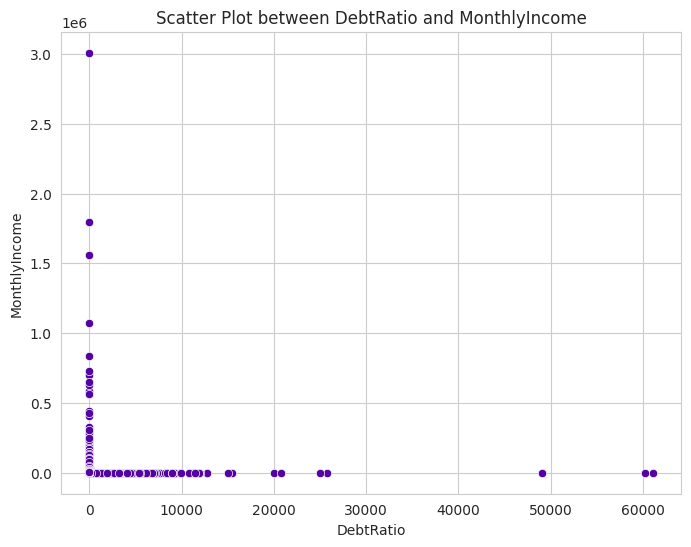

In [169]:
scatter_plot('DebtRatio', 'MonthlyIncome')

In [162]:
prt_corr('DebtRatio', 'SeriousDlqin2yrs')

Correlation between DebtRatio and SeriousDlqin2yrs: -0.007069090389288254


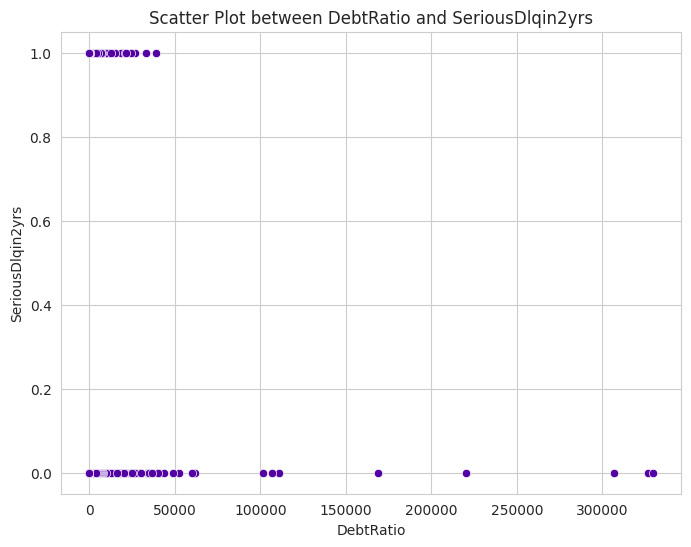

In [137]:
scatter_plot('DebtRatio', 'SeriousDlqin2yrs')

In [163]:
df_train["DebtRatio"].quantile(0.95)

2452.0

In [164]:
df_train.loc[df_train["DebtRatio"] > df_train["DebtRatio"].quantile(0.95)][["DebtRatio", "MonthlyIncome", "SeriousDlqin2yrs"]].describe()

,DebtRatio,MonthlyIncome,SeriousDlqin2yrs
count,7483.000000,378.000000,7483.000000
mean,4420.849258,0.084656,0.055192
std,7880.740374,0.278738,0.228369
min,2453.000000,0.000000,0.000000
25%,2895.000000,0.000000,0.000000
50%,3492.000000,0.000000,0.000000
75%,4622.000000,0.000000,0.000000
max,329664.000000,1.000000,1.000000


The code aims to analyze and describe the subset of the df_train DataFrame where the `DebtRatio` is in the **top 5%** of values. It provides insights into the distribution of `DebtRatio`, `MonthlyIncome`, and `SeriousDlqin2yrs` within this subset.

In [165]:
len(df_train[(df_train["DebtRatio"] > df_train["DebtRatio"].quantile(0.95)) & (df_train['SeriousDlqin2yrs'] == df_train['MonthlyIncome'])])

330

In [166]:
df_train.loc[df_train["DebtRatio"] > df_train["DebtRatio"].quantile(0.95)]["MonthlyIncome"].value_counts()

0.0    346
1.0     32
Name: MonthlyIncome, dtype: int64

In [153]:
# Set upper bound as the 95th percentile
upper_bound = df_train['DebtRatio'].quantile(0.95)

# Apply winsorizing using .loc[]
df_train.loc[df_train['DebtRatio'] > upper_bound, 'DebtRatio'] = upper_bound

In [154]:
df_train["DebtRatio"].describe()

count    149731.000000
mean          1.089261
std           1.494799
min           0.000000
25%           0.175998
50%           0.367119
75%           0.870021
max           4.000000
Name: DebtRatio, dtype: float64

In [ ]:
prt_corr('DebtRatio', 'SeriousDlqin2yrs')

                  DebtRatio  MonthlyIncome  SeriousDlqin2yrs
DebtRatio          1.000000      -0.028736         -0.007069
MonthlyIncome     -0.028736       1.000000         -0.019119
SeriousDlqin2yrs  -0.007069      -0.019119          1.000000


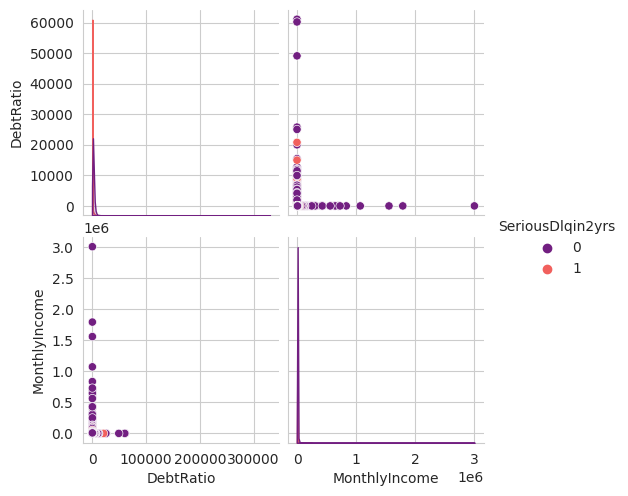

In [138]:
# Select relevant columns
selected_columns = ["DebtRatio", "MonthlyIncome", "SeriousDlqin2yrs"]
df_selected = df_train[selected_columns]

# Calculate the correlation matrix
correlation_matrix = df_selected.corr()

# Display the correlation matrix
print(correlation_matrix)

# Plot a pair plot
sns.pairplot(data=df_selected, hue='SeriousDlqin2yrs', palette='magma')
plt.show()

### NULL Values

In [18]:
null_val = df_train.isnull().sum()
pd.DataFrame({"Column": null_val.index, "Number of Null Values": null_val.values, "ratio": null_val.values / len(df_train) })

,Column,Number of Null Values,ratio
0,SeriousDlqin2yrs,0,0.000000
1,RevolvingUtilizationOfUnsecuredLines,0,0.000000
2,age,0,0.000000
3,NumberOfTime30-59DaysPastDueNotWorse,0,0.000000
4,DebtRatio,0,0.000000
5,MonthlyIncome,29731,0.198207
6,NumberOfOpenCreditLinesAndLoans,0,0.000000
7,NumberOfTimes90DaysLate,0,0.000000
8,NumberRealEstateLoansOrLines,0,0.000000
9,NumberOfTime60-89DaysPastDueNotWorse,0,0.000000
